In [17]:
import os
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import cv2
import numpy as np
from keras.applications import VGG16
from scipy.spatial import distance
from tsp_solver.greedy import solve_tsp

# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = os.getcwd()
VGG16_FEATURES = os.path.join(BASE_DIR, 'handwriting_gen_vgg16_features.npy')
IMG_FILES_PATTERN = os.path.join(BASE_DIR, 'data/handwriting_gen/*_crop.jpg')
JSON_FILES_PATTERN = os.path.join(BASE_DIR, 'data/handwriting_gen/*.json')

def _img_files():
    return sorted(glob(IMG_FILES_PATTERN, recursive=True))

def _json_files():
    return sorted(glob(JSON_FILES_PATTERN, recursive=True))

In [18]:
imgs = _img_files()
print(len(imgs))
jsons = _json_files()
print(len(jsons))

137
0


In [19]:
def _resize_img(file):
    print(file)
    img = cv2.imread(os.path.join(BASE_DIR, "%s" % file))
    resized = cv2.resize(img, (128, 64))
    return resized

In [4]:
def _extract_features(files):
#     files = _img_files()
    images = np.array([_resize_img(f) for f in files])

    model = VGG16(include_top=False, input_shape=(64, 128, 3), pooling='avg')
    model.summary()

    features = model.predict(images)
    np.save(VGG16_FEATURES, features)

In [18]:
def _img_json_files():
    jsons = _json_files()
    files = ["data/handwriting/%s.jpg" % os.path.splitext(os.path.basename(f))[0] for f in jsons]
    return files

In [20]:
def label_images(n_splits=5):
    # Extract image features
    print('extract_features')
    if not os.path.exists(VGG16_FEATURES):
        files = _img_files()
        _extract_features(files)
    print('load feature')
    vgg16_features = np.load(VGG16_FEATURES)
    print('Loaded VGG16 features: ', vgg16_features.shape)

    print('sort images')
    # Sort images by similarity
    pdists = distance.pdist(vgg16_features)
    D = distance.squareform(pdists)
    path = solve_tsp(D)

    # Debug
    if True:
        import matplotlib.pyplot as plt
        files = _img_files()
        for p in path:
            print(p)
            img = cv2.imread(files[p])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.show()

    # Make n_splits labels
    labels = np.zeros(vgg16_features.shape[0]).astype(int)
    for idx, p in enumerate(path):
        labels[p] = idx % n_splits
    print(np.unique(labels))
    return labels

extract_features
load feature
Loaded VGG16 features:  (313, 512)
sort images
90


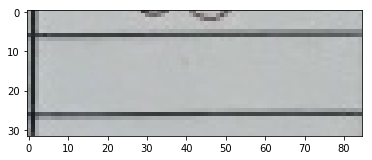

77


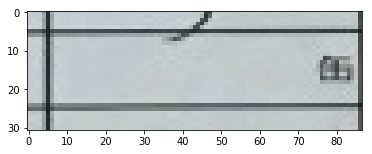

94


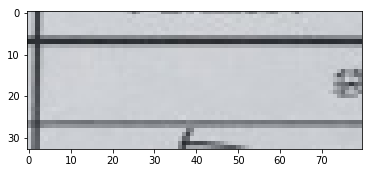

52


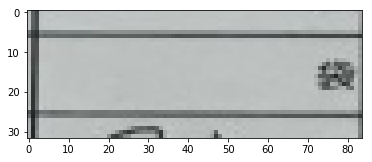

47


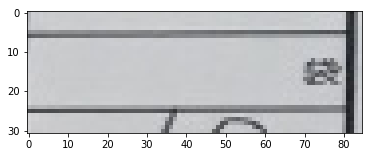

88


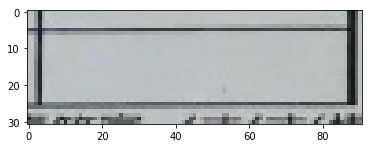

39


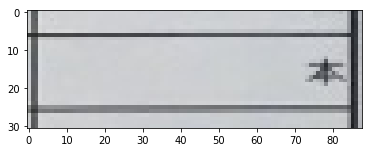

58


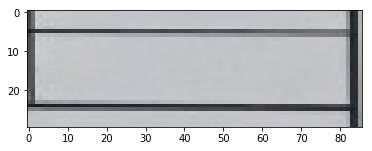

36


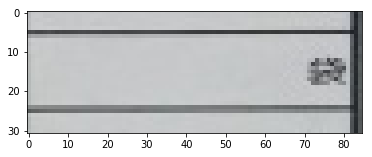

109


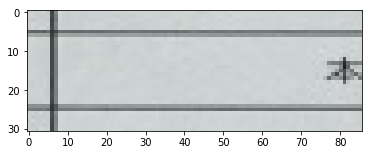

104


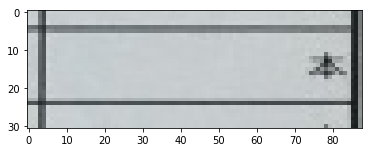

113


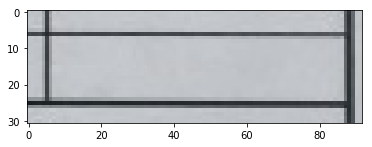

103


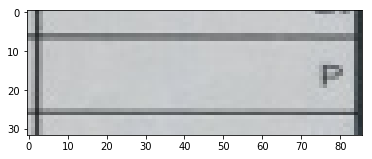

105


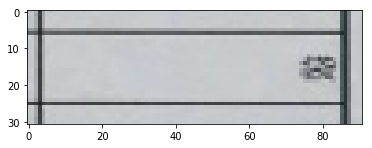

119


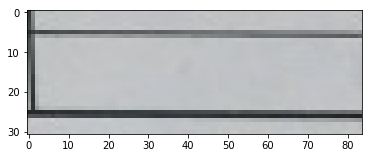

42


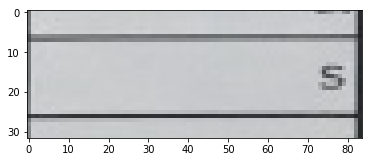

151


IndexError: list index out of range

In [21]:
# if __name__ == '__main__':
images = label_images()
index_train_cv = np.where(images != 0)
index_valid_cv = np.where(images == 0 )
files = _img_files()

X_train_cv = [x for x in files if files.index(x) in index_train_cv[0]]
X_valid = [x for x in files if files.index(x) in index_valid_cv[0]]

# print(X_train_cv)
print(len(X_train_cv))
print(len(X_valid))

if False:
    import matplotlib.pyplot as plt
    for p in X_valid:
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()